# Loading the Dataset

In [19]:
import pandas as pd
drug_df = pd.read_csv(r'Data\drug_data.csv')
drug_df =drug_df.sample(frac=1)
drug_df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
16,69,M,LOW,NORMAL,11.455,drugX
162,43,M,NORMAL,NORMAL,12.859,drugX
170,28,F,NORMAL,HIGH,12.879,drugX
174,42,M,HIGH,NORMAL,12.766,drugA
175,73,F,HIGH,HIGH,18.348,DrugY


# Train Test Split

In [20]:
from sklearn.model_selection import train_test_split

X = drug_df.drop('Drug', axis=1)
y = drug_df.Drug.values

X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Machine Learning Pipelines

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler


cat_col = [1,2,3]
num_col = [0,4]

transform = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(), cat_col),
        ("num_imputer", SimpleImputer(strategy = "median"), num_col),
        ("num_sclaer", StandardScaler(), num_col)
    ]
)

pipe = Pipeline(
    steps = [
        ("preprocessing", transform),
        ("model", RandomForestClassifier(n_estimators=100, random_state=42))
    ]
)

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('encoder', OrdinalEncoder(),
                                                  [1, 2, 3]),
                                                 ('num_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  [0, 4]),
                                                 ('num_sclaer',
                                                  StandardScaler(), [0, 4])])),
                ('model', RandomForestClassifier(random_state=42))])

# Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

predictions = pipe.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average="macro")

print("Accuracy:", str(round(accuracy, 2) * 100) + "%", "F1:", round(f1, 2))

Accuracy: 90.0% F1: 0.91


In [24]:
with open("Results/metrics.txt", "w") as outfile:
    outfile.write(f"\nAccuracy = {round(accuracy, 2)}, F1 Score = {round(f1, 2)}.")

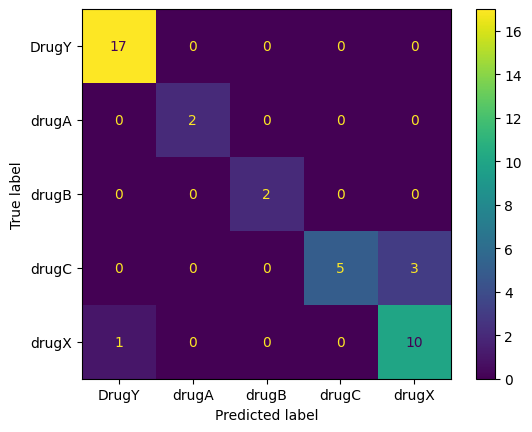

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, predictions, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()
plt.savefig("Results/model_results.png", dpi=120)

# Saving the Model

In [28]:
# !pip install skops
import skops.io as sio

sio.dump(pipe, "Model/drug_pipeline.skops")

In [32]:
from skops.io import get_untrusted_types
import skops.io as sio

# Identify untrusted types from the specific file
untrusted_types = get_untrusted_types(file="Model/drug_pipeline.skops")

# Load the model, using the identified untrusted types as trusted
pipeline = sio.load("Model/drug_pipeline.skops", trusted=untrusted_types)